In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import trim_mean

In [26]:
folder_path = r"C:\Users\alvar\Desktop\TELECO\cuarto\Thesis\Nash-DQN-RAT\Nash DQN - RAT\Data_analysis\LTE Dataset/pedestrian"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
df = pd.concat((pd.read_csv(file) for file in all_files), ignore_index=True)

print(len(df))
df.head()

33629


,Timestamp,Longitude,Latitude,Speed,Operatorname,CellID,NetworkMode,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,NRxRSRP,NRxRSRQ,ServingCell_Lon,ServingCell_Lat,ServingCell_Distance
0,2017.11.21_15.03.50,-8.499701,51.893336,0,A,2,LTE,-95,-13,4.0,10,-80,0,0,D,-,-,-8.491719,51.893905,551.37
1,2017.11.21_15.03.51,-8.499701,51.893336,0,A,2,LTE,-95,-13,2.0,8,-78,0,0,I,-,-,-8.491719,51.893905,551.37
2,2017.11.21_15.03.52,-8.499733,51.893346,0,A,2,LTE,-95,-13,13.0,9,-80,0,0,I,-,-,-8.491719,51.893905,553.42999999999995
3,2017.11.21_15.03.52,-8.499733,51.893346,0,A,2,LTE,-95,-13,13.0,9,-80,0,0,I,-,-,-8.491719,51.893905,553.42999999999995
4,2017.11.21_15.03.53,-8.499887,51.893384,1,A,2,LTE,-95,-13,13.0,9,-80,0,0,I,-,-,-8.491719,51.893905,563.48000000000002


Delete non valid measurements '-'

In [27]:
lte_df_clean = df[['CQI','ServingCell_Distance']].copy()

lte_df_clean['CQI'] = pd.to_numeric(lte_df_clean['CQI'], errors='coerce')
lte_df_clean['ServingCell_Distance'] = pd.to_numeric(lte_df_clean['ServingCell_Distance'], errors='coerce')
print(len(lte_df_clean))
lte_df_clean = lte_df_clean.dropna().reset_index(drop=True)

33629


In [28]:
lte_df_csv = lte_df_clean.copy()
lte_df_csv.rename(columns={'ServingCell_Distance': 'Distance', 'CQI': 'CQI'}, inplace=True)
lte_df_csv = lte_df_csv[['Distance', 'CQI']]
lte_df_csv.to_csv("cqi_distance.csv",index = False)

Divide the dataset in blocks of samples

In [29]:
lte_df_clean = lte_df_clean.sort_values(by='ServingCell_Distance')

n_blocks = len(lte_df_clean) 
block_size = len(lte_df_clean) // n_blocks

lte_df_clean['block'] = 0
for n in range(1, n_blocks + 1):
    start_idx = (n - 1) * block_size
    end_idx = n * block_size
    lte_df_clean.loc[start_idx:end_idx - 1, 'block'] = n

print(f"Clean dataset size: {len(lte_df_clean)}")
print(lte_df_clean.head(10))

Clean dataset size: 31205
       CQI  ServingCell_Distance  block
8978   2.0                 49.30   8979
8979   7.0                 49.30   8980
8980   7.0                 49.30   8981
8981   7.0                 49.30   8982
17120  4.0                 52.41  17121
17125  2.0                 52.41  17126
17124  4.0                 52.41  17125
17123  3.0                 52.41  17124
17122  4.0                 52.41  17123
17121  4.0                 52.41  17122


Print blocks

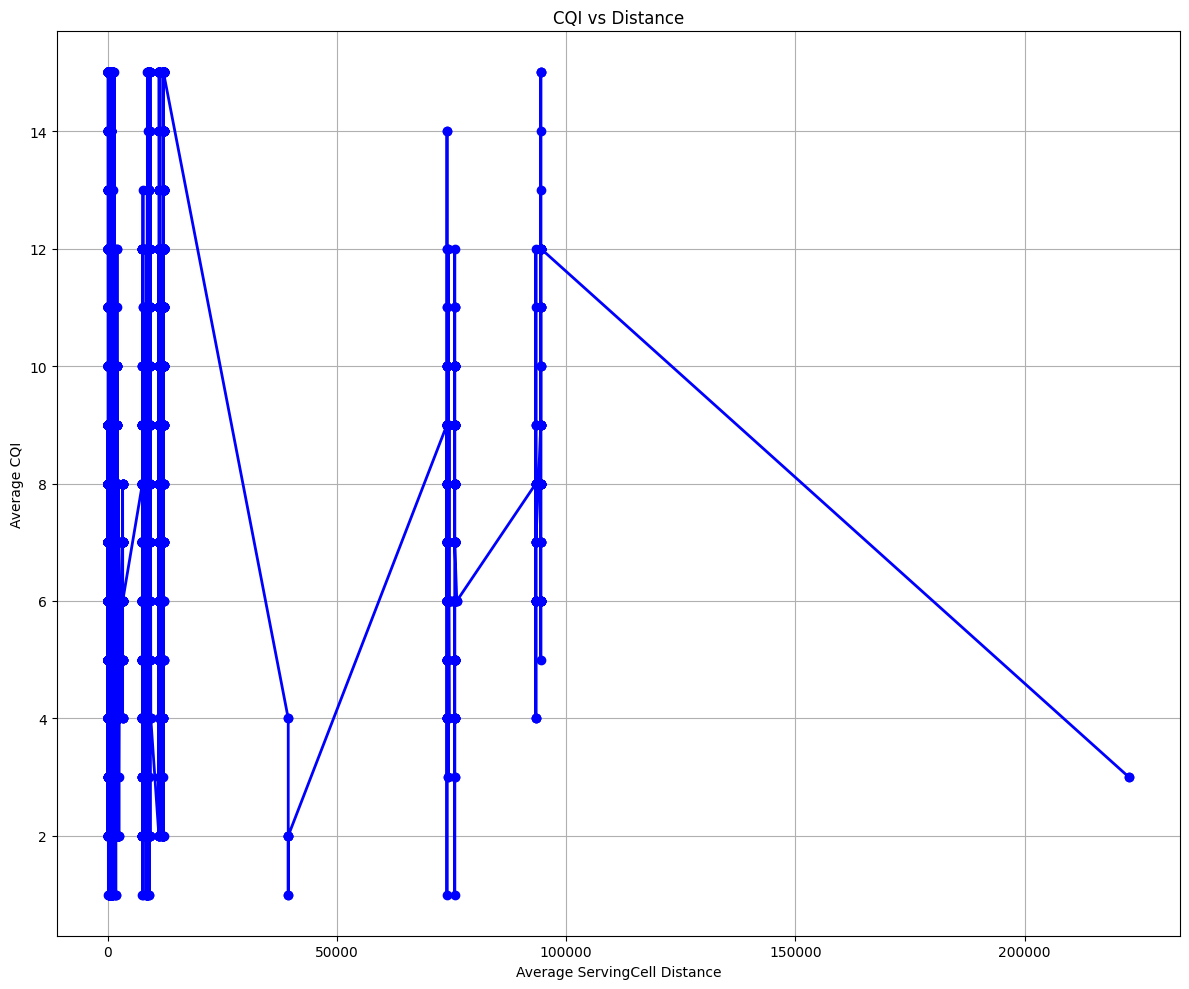

In [30]:
def trimmed_mean(series):
    return trim_mean(series, proportiontocut=0.1)  # Trims 10% from both ends

block_means = lte_df_clean.groupby('block').agg({
    'ServingCell_Distance': lambda x: trimmed_mean(x),
    'CQI': lambda x: trimmed_mean(x),
}).reset_index()

block_means = block_means.sort_values(by='ServingCell_Distance').reset_index(drop=True)

fig, ax = plt.subplots( figsize=(12, 10))


ax.plot(block_means['ServingCell_Distance'], block_means['CQI'], color='blue', marker='o', linestyle='-', linewidth=2)
ax.set_title('CQI vs Distance')
ax.set_xlabel('Average ServingCell Distance')
ax.set_ylabel(f'Average {'CQI'}')
ax.grid(True)

plt.tight_layout()
plt.show()


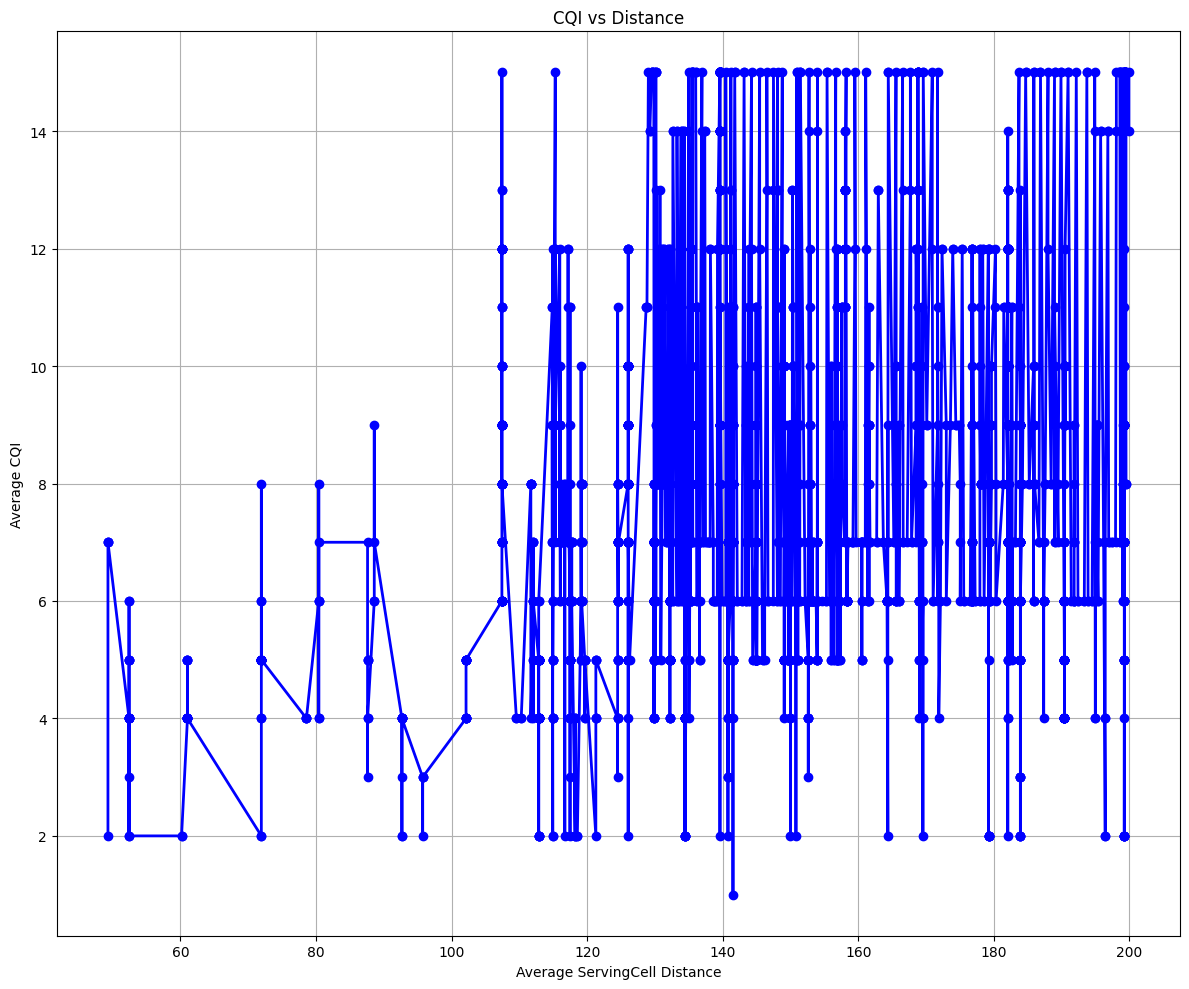

In [31]:
block_means_filtered = block_means[block_means['ServingCell_Distance'] < 200]
fig, ax = plt.subplots( figsize=(12, 10))


ax.plot(block_means_filtered['ServingCell_Distance'], block_means_filtered['CQI'], color='blue', marker='o', linestyle='-', linewidth=2)
ax.set_title('CQI vs Distance')
ax.set_xlabel('Average ServingCell Distance')
ax.set_ylabel(f'Average {'CQI'}')
ax.grid(True)

plt.tight_layout()
plt.show()

Divide the dataset in blocks of 50 m

This database has a length of  15261
228.86 979.1
Clean dataset size: 12085
[ 1.  2.  7.  8. 13. 15. 16. 17. 18. 28. 31.]


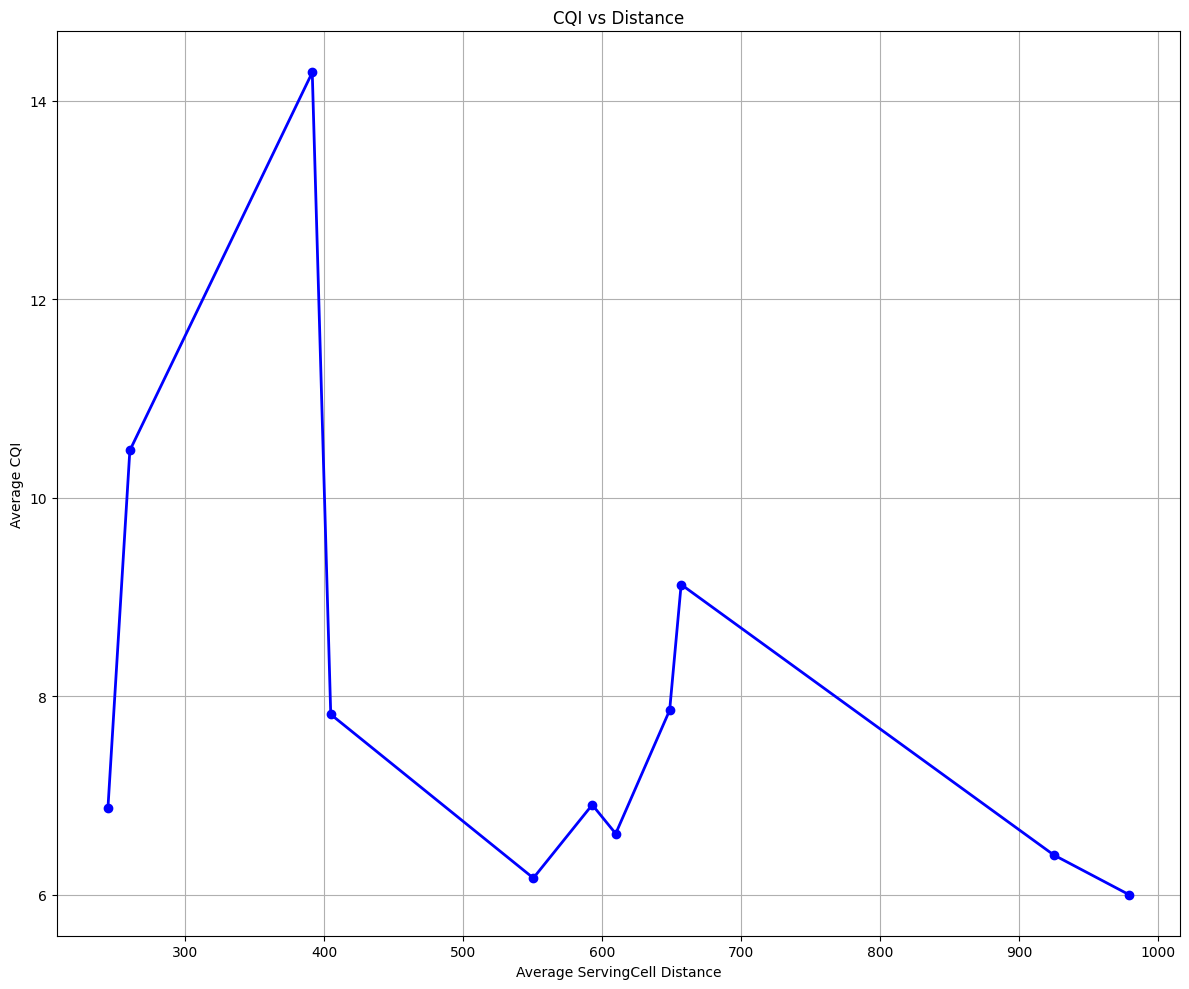

In [32]:
lte_df = pd.read_csv("LTE Dataset/static/joined_lte_database.csv", sep=',')
print("This database has a length of ", len(lte_df))

lte_df_clean = lte_df[['CQI','ServingCell_Distance']].copy()
lte_df_clean['CQI'] = pd.to_numeric(lte_df_clean['CQI'], errors='coerce')
lte_df_clean['ServingCell_Distance'] = pd.to_numeric(lte_df_clean['ServingCell_Distance'], errors='coerce')
lte_df_clean = lte_df_clean.dropna().reset_index(drop=True)

lte_df_clean = lte_df_clean.sort_values(by='ServingCell_Distance')

block_size = 25
min_distance = lte_df_clean['ServingCell_Distance'].min()
max_distance = lte_df_clean['ServingCell_Distance'].max()
print(min_distance,max_distance)

lte_df_clean['block'] = ((lte_df_clean['ServingCell_Distance'] - min_distance) // block_size) + 1

print(f"Clean dataset size: {len(lte_df_clean)}")
print(lte_df_clean['block'].unique())

def trimmed_mean(series):
    return trim_mean(series, proportiontocut=0.1)

# Calcular las medias para cada bloque
block_means = lte_df_clean.groupby('block').agg({
    'ServingCell_Distance': lambda x: trimmed_mean(x),
    'CQI': lambda x: trimmed_mean(x),
}).reset_index()

block_means = block_means.sort_values(by='ServingCell_Distance').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, 10))

ax.plot(block_means['ServingCell_Distance'], block_means['CQI'], color='blue', marker='o', linestyle='-', linewidth=2)
ax.set_title('CQI vs Distance')
ax.set_xlabel('Average ServingCell Distance')
ax.set_ylabel(f'Average {'CQI'}')
ax.grid(True)

plt.tight_layout()
plt.show()


### Creat datasets (CQI, distance from cell)

In [33]:
lte_df['ServingCell_Distance'] = pd.to_numeric(lte_df['ServingCell_Distance'], errors='coerce')
lte_df = lte_df.dropna().reset_index(drop=True)

lte_df_CQI = lte_df[['CQI', 'ServingCell_Distance']].copy()

lte_df_CQI['CQI'] = pd.to_numeric(lte_df_CQI['CQI'], errors='coerce')
lte_df_CQI = lte_df_CQI.dropna().reset_index(drop=True)


### Average distance for every CQI ###

In [34]:
CQI_stats = lte_df_CQI.sort_values(by = 'CQI').groupby('CQI')['ServingCell_Distance'].agg(['mean', 'std', 'min', 'max'])
print(CQI_stats)

           mean         std     min     max
CQI                                        
2    778.458696  279.053479  260.63  922.30
4    610.846667  359.574438  260.63  979.10
5    865.687057  174.464068  230.87  928.09
6    617.282207  242.637211  228.86  979.10
7    618.597934  158.318834  228.86  928.09
8    503.464796  214.768443  228.86  928.09
9    646.205478  186.659177  228.86  928.09
10   512.852390  185.423260  228.86  660.10
11   515.182613  185.193769  228.86  660.10
12   590.942351  142.963716  228.86  660.10
13   480.429650  190.406118  259.65  660.10
14   327.894312  143.913069  259.65  637.30
15   353.796400  161.246975  259.65  637.30


Plot results

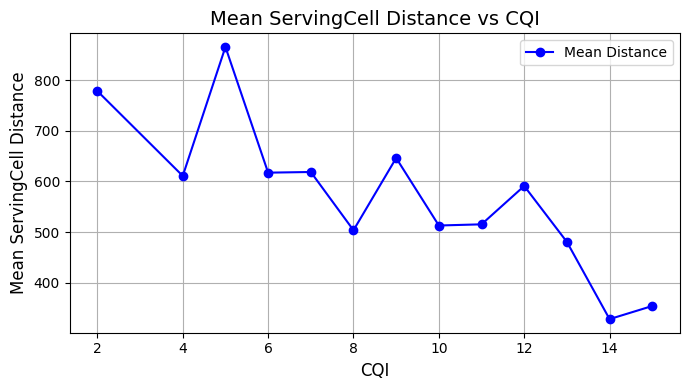

In [35]:
plt.figure(figsize=(7, 4))
plt.plot(CQI_stats.index, CQI_stats['mean'], marker='o', linestyle='-', color='blue', label='Mean Distance')
plt.title('Mean ServingCell Distance vs CQI', fontsize=14)
plt.xlabel('CQI', fontsize=12)
plt.ylabel('Mean ServingCell Distance', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()